In [1]:
!pip uninstall tensorflow -y
!pip  install transformers==4.22.1 -q
!pip install evaluate

     ---------------------------------------- 21.5/21.5 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1


In [1]:
import transformers
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, \
                         DataCollatorWithPadding, pipeline
from transformers import DataCollatorWithPadding
import evaluate
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, \
                            roc_auc_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scikitplot as skplt

In [2]:
import load_data
from load_data import Data
import train_datasets
from train_datasets import Train_dataset

In [3]:
def load_dataset():
    #Load a datafraom from the Data class from load_data
    data.handle_file()
    data.convert_json_to_dataframe()
    data.get_next_value()
    data.compare_values()
    data.label_sentences()
    data.initial_df()

In [4]:
def check_balance(a):
    #Checking ratio of values in label variable
    a = pd.DataFrame(a)
    print(a.value_counts())
    print(round(a.value_counts()[0]/len(a)*100,2),"%", ":" , round(a.value_counts()[1]/len(a)*100,2),"%", end='\n')    

In [5]:
def preprocess_function(dataset):
    #Mapping tokenizer with a dataset
    return tokenizer(dataset["text"], truncation=True, max_length=400)

In [6]:
metric = evaluate.combine(["accuracy","recall","precision", "f1"])
def compute_metrics(eval_pred):
    #Setting evaluation metrics
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [7]:
def training_model():
    #Defining Model and training arguments 
    #Training model with splitted dataset
    uni_labels = ['Continue', "Change"]
    sequence_clf_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels = 2)
    sequence_clf_model.config.id2label = {i: l for i, l in enumerate(uni_labels)}
    sequence_clf_model.config.dropout =0.2

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.05,
        logging_dir='./logs',
        load_best_model_at_end=True,
        logging_steps=1,
        log_level='info',
        evaluation_strategy='epoch',
        eval_steps=100,
        save_strategy='epoch'
    )

    trainer1 = Trainer(
        model=sequence_clf_model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['test1'],
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    trainer2 = Trainer(
        model=sequence_clf_model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['test2'],
        compute_metrics=compute_metrics,
        data_collator=data_collator
    ) 
    
    return trainer1, trainer2

In [8]:
def get_predictions(pred_list):
    #Getting label values from probabilities
    p = []
    for pred in pred_list:
        if pred[0] > pred[1]:
            p.append(0)
        else:
            p.append(1)        
    return p

In [9]:
def evaluate_model(labels, prediction, pred):
    confusion = confusion_matrix(labels, prediction)
    accuracy = accuracy_score(labels, prediction)
    precison = precision_score(labels, prediction)
    recall = recall_score(labels, prediction)
    f1 = f1_score(labels, prediction)
    
    print("accuracy : ",accuracy)
    print("precison : ", precison)
    print("recall : ", recall)
    print("f1 :", f1)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')

    skplt.metrics.plot_roc_curve(labels, pred)
    plt.show()

['Yes.'
 "I'd like to know like the room details and what the hotels offer."
 'The warm,' 'modern suites offer free Wi-Fi,'
 'flat-screen TVs and DVD players.' 'All have desks,'
 'sitting areas and kitchens.' 'Amenities include a refined bar/lounge,'
 'a 24-hour gym and a 24/7 business center.' ''
 'a 24-hour gym and a 24/7 business center.' 'Okay.'
 'I definitely want Wi-Fi in my room.' 'Ok great!'
 "And I'd also like to ask about the different offerings the hotel has."
 'A free breakfast buffet is served in the relaxed dining room.'
 'All have desks,' 'sitting areas and kitchens.' ''
 'sitting areas and kitchens.' 'Okay.'
 'I definitely want a hotel with a breakfast.' 'And is that all?'
 'I just wanted to make sure it was a two-person room.'
 'Yes for 2 to 3 people.' 'Okay.' "That's it."
 'The hotel is Staybridge Suites Times Square - New York City.' 'Okay,'
 'cool.']
[0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1]
['Yes.', "Yes. I'd", "Yes. I'd like", "Yes. I'd like to

,text,label,count
0,Hello!,0,1
1,How can I help you?,1,5
2,"Hi,",0,1


(105030, 3)
0    53659
1    51371
Name: label, dtype: int64


Dataset to be used for modeling
(5000, 3)


,text,label,count
5000,Yes.,0,1
5001,I'd like to know like the room details and wha...,1,13
5002,"The warm,",0,2
5003,"modern suites offer free Wi-Fi,",0,5
5004,flat-screen TVs and DVD players.,0,5




Sentences
['Yes.', "I'd like to know like the room details and what the hotels offer.", 'The warm,', 'modern suites offer free Wi-Fi,', 'flat-screen TVs and DVD players.', 'All have desks,', 'sitting areas and kitchens.', 'Amenities include a refined bar/lounge,', 'a 24-hour gym and a 24/7 business center.', 'a 24-hour gym and a 24/7 business center.']
Tokenized sentences
['Yes.', "I'd", 'like', 'to', 'know', 'like', 'the', 'room', 'details', 'and', 'what', 'the', 'hotels', 'offer.', 'The', 'warm,', 'modern', 'suites', 'offer', 'free']
Labels
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
length of train_dataset.sequences 22760
length of train_dataset.labels 22760
length of train_dataset.sequences 27255
length of train_dataset.labels 27255


Generated Sequences
['Yes.', "Yes. I'd", "Yes. I'd like", "Yes. I'd like to", "Yes. I'd like to know", "Yes. I'd like to know like", "Yes. I'd like to know like the", "Yes. I'd like to know like the room", "Yes. I'd like to know lik

Map:   0%|          | 0/16353 [00:00<?, ? examples/s]

Map:   0%|          | 0/5451 [00:00<?, ? examples/s]

Map:   0%|          | 0/5451 [00:00<?, ? examples/s]



Converted Sequences
{'label': 0, 'text': 'The second is called stanford court hotel.', 'input_ids': [101, 1109, 1248, 1110, 1270, 188, 5108, 2821, 2175, 3415, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}



Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.wei

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.000100,0.108463,0.956889,0.998581,0.857927,0.922926
2,0.000400,0.106346,0.956889,0.978708,0.870581,0.921483
3,0.014600,0.114082,0.957622,0.986515,0.867665,0.923281
4,0.000000,0.131740,0.955238,0.950319,0.884997,0.916496


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5451
  Batch size = 64
Saving model checkpoint to ./results\checkpoint-1023
Configuration saved in ./results\checkpoint-1023\config.json
Model weights saved in ./results\checkpoint-1023\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5451
  Batch size = 64
Saving model checkpoint to ./results\checkpoint-2046
Configuration saved in ./results\checkpoint-2046\config.json
Model weights saved in 

accuracy :  0.9568886442854522
precison :  0.8705808080808081
recall :  0.978708303761533
f1 : 0.9214834614099566


C:\Users\singg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


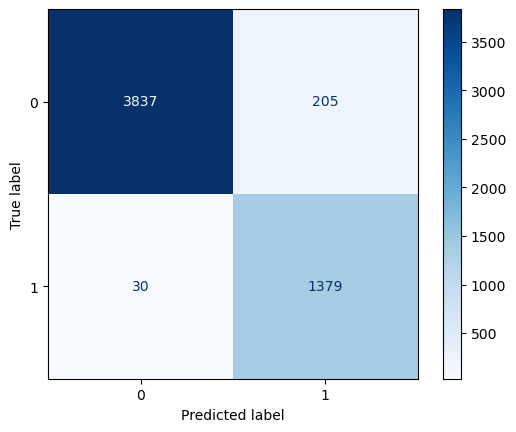

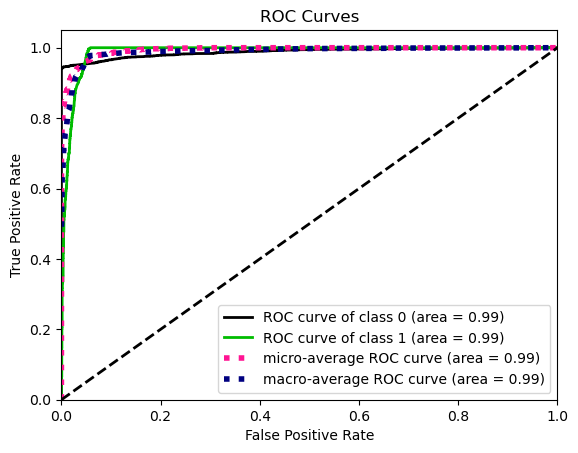

In [10]:
if __name__ == '__main__':
    #=============================================
    #Generating additional data with label 1======================
    path ='hotels.json'
    data = Data(path)
    load_dataset()
    df = data.df.to_json("df.json")

    t = data.df.copy()
    t = t[5000:14500]

    #Splitting setences to tokens and labeling tokens
    train_dataset = Train_dataset(t) 
    train_dataset.test_text = t['text'].values
    train_dataset.test_label = t['label'].values
    print(train_dataset.test_text[:30])
    print(train_dataset.test_label[:30])

    train_dataset.split_token_sentences()
    train_dataset.tokenized_text_label = train_dataset.flatten_list(train_dataset.tokenized_text_label)
    train_dataset.tokenized_text = train_dataset.flatten_list(train_dataset.tokenized_text)
    train_dataset.generate_test_dataset()

    print(train_dataset.sequences[:14])
    print(train_dataset.labels[:14])

    text_shift = []
    label_shift = []

    for i, l in enumerate(train_dataset.labels):
        if l == 1:
            text_shift.append(train_dataset.sequences[i])
            label_shift.append(l)
        
    print(len(text_shift))
    print(len(label_shift))

    #============================================
    #Generate a df from Data class from data_load
    #A df contains "texc" column a sentence per a row and their lables(0: continue, 1: change)
    data = Data(path)
    load_dataset()
    print("\n\nInitial Data")
    display(data.df[:3])
    print(data.df.shape)
    print(data.df['label'].value_counts())
    #save initial df as a json file
    df = data.df.to_json("df.json")

    #============================================
    #Preprocessing data for modeling
    #t = df.copy()
    t = t[:5000]
    #4000 rows were used which will generate sequences.
    print("\n\nDataset to be used for modeling")
    print(t.shape)
    display(t[:5])
    #Converting columns to list for tokenizing

    #Splitting setences to tokens and labeling tokens
    train_dataset = Train_dataset(t) 
    train_dataset.test_text = t['text'].values
    train_dataset.test_label = t['label'].values
    
    train_dataset.split_token_sentences()
    train_dataset.tokenized_text_label = train_dataset.flatten_list(train_dataset.tokenized_text_label)
    train_dataset.tokenized_text = train_dataset.flatten_list(train_dataset.tokenized_text)
    print("\n\nSentences")
    print(train_dataset.text[:10])
    print("Tokenized sentences")
    print(train_dataset.tokenized_text[:20])
    print("Labels")
    print(train_dataset.tokenized_text_label[:20])

    #Generating sequnces to be used for training by combining tokens and labeling the sequences
    train_dataset.generate_test_dataset()
    print("length of train_dataset.sequences", len(train_dataset.sequences))
    print("length of train_dataset.labels", len(train_dataset.labels))
    
    #Add additional data with label 1    
    p = train_dataset.sequences
    p.extend(text_shift)
    train_dataset.sequences = p
    q=train_dataset.labels
    q.extend(label_shift)
    train_dataset.labels =q
    print("length of train_dataset.sequences", len(train_dataset.sequences))
    print("length of train_dataset.labels", len(train_dataset.labels))
    
    print("\n\nGenerated Sequences")
    print(train_dataset.sequences[:10])
    print("Lables for each sequences")
    print(train_dataset.labels[:10])
    print("The number of generated Sequences")
    print(len(train_dataset.sequences))

    #Generating datasets for training, vaildating and testing
    train_dataset.datasets_for_training()
    print("\n\nDatasets for training and evaluating models")
    print(train_dataset.dataset, end="\n\n")

    #Applying DistilBertTokenizerFast for DistilBert model
    dataset = train_dataset.dataset
    
    print("Checking the value ratio of the label variable")
    print("train dataset")
    check_balance(dataset['train']['label'])
    print("validation dataset")
    check_balance(dataset['test1']['label'])
    print("test dataset")
    check_balance(dataset['test2']['label'])

    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased', ignore_mismatched_sizes=True)
    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    print("\n\nConverted Sequences")
    print(tokenized_dataset['train'][15], end="\n\n")

    #padding dataset
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    
    #training and saving models
    trainer1, trainer2 = training_model()
    
    #trainer1.evaluate()
    #tarining modesl with preprocessed dataset
    trainer1.train()    
    trainer1.save_model('./model/test_bert_distilbert_seq_token')
    
    prediction1 = trainer1.predict(trainer1.eval_dataset)
    pred  = list(prediction1[0])
    labels  = list(prediction1[1])
    prediction = get_predictions(pred)
    evaluate_model(labels, prediction, pred)
    #evaluation trained model
    #trainer1.evaluate()
    #evaluation model with another dataset
    #trainer2.evaluate()

In [11]:
trainer2.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5451
  Batch size = 64


{'eval_loss': 0.09380971640348434,
 'eval_accuracy': 0.9618418638781875,
 'eval_recall': 0.9870036101083033,
 'eval_precision': 0.8779704560051381,
 'eval_f1': 0.929299796057104,
 'eval_runtime': 644.3271,
 'eval_samples_per_second': 8.46,
 'eval_steps_per_second': 0.133}